# Sentiment Analysis with QNLP - More advanced classification

In this project will will code a binary sentiment analysis with more predictive value compared to the previous binary classification. We will try to predict for a sentcne, whether it is *Positive*, *Negative*, *Neutral* or a *Mix* .

In [1]:
from lambeq import BobcatParser, SpacyTokeniser
import torch, numpy, pandas as pd, re

In [2]:
# Number of classes
n_classes = 4

In [3]:
# Function for the converting of labels into a list
def create_list(num,maxi):
    lst = [0] * maxi
    lst[num] = 1
    return lst

Let us read the files with the sentences, clean them and put the sentences into a new files.

In [4]:
def clean_text(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """        
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)

    text =  ' '.join(text.split())
    #print(text)
    return text

In [5]:
def process_csv_lines(input_file_path, output_file_path):
    """
    Reads a CSV file, processes each line to remove all commas except the last one,
    and writes the processed lines to a new file.
    """
    with open(input_file_path, 'r', encoding='utf-8') as input_file, open(output_file_path, 'w', encoding='utf-8') as output_file:
        for line in input_file:
            if ',' in line:
                parts = line.rsplit(',', 1)  # Split from the right at the last comma
                new_line = parts[0].replace(',', '') # Remove all commas from the first part
            else:
                new_line = line  # If no comma is present, leave the line unchanged
            
            output_file.write(clean_text(new_line)+ ',' + parts[1])



In [6]:
# Process Train dataset 
input_file = "dataset_dim4/train_dataset.csv"
output_file = "dataset_dim4/train_clean_data.csv"
process_csv_lines(input_file,output_file)

In [7]:
# Process Test dataset
input_file = "dataset_dim4/test_dataset.csv"
output_file = "dataset_dim4/test_clean_data.csv"
process_csv_lines(input_file,output_file)

In [8]:
# Extract the cleaned sentences and shuffle them
column_names = ["text", "label"]
train_dataset = pd.read_csv("dataset_dim4/train_clean_data.csv", names=column_names).sample(frac = 1, )
test_dataset = pd.read_csv("dataset_dim4/test_clean_data.csv", names=column_names).sample(frac = 1)

Let us have a look at the values we are dealing with

In [9]:
train_dataset[:10]

,text,label
123,unfortunately the meal did not live up to the ...,1
102,their dedication to quality is evident in ever...,0
87,an enlightening book though somewhat preachy i...,3
15,their kindness and professionalism were unmatched,0
130,the dessert looked enticing but its taste was ...,3
81,groundbreaking scientific discovery with far r...,0
17,this restaurant is hidden gem,0
120,the product did not meet my expectations in te...,1
85,meticulously researched article albeit with na...,2
55,as advertised no more no less,2


In [10]:
test_dataset[:10]

,text,label
23,the quality of the craftsmanship is evident in...,0
27,the conference was well organized featuring in...,0
39,the cars performance is unmatched but the inte...,3
30,the scenery was breathtaking yet the accommoda...,3
29,their commitment to sustainability is both gen...,0
34,the meal was exquisite though found the portio...,3
5,the package weighs approximately kilograms,2
1,the temperature today is expected to reach hig...,2
16,service charges were not mentioned upfront lea...,1
2,the meeting is scheduled for pm tomorrow,2


In [11]:
from lambeq import SpacyTokeniser

tokeniser = SpacyTokeniser()
# Tokenise the sentences
train_data = [tokeniser.tokenise_sentence(sent) for sent in train_dataset.iloc[:, 0].to_list()]
train_labels = [create_list(ele,n_classes) for ele in train_dataset.iloc[:, 1].to_list()]
test_data = [tokeniser.tokenise_sentence(sent) for sent in test_dataset.iloc[:, 0].to_list()]
test_labels = [create_list(ele,n_classes) for ele in test_dataset.iloc[:, 1].to_list()]

#train_labels = [[1-x, x] for x in train_dataset.iloc[:, 1].to_list()]
#test_labels = [[1-x, x] for x in test_dataset.iloc[:, 1].to_list()]

## Text -> Diagram

In this section we look at how to go from text to diagram

In [12]:
#Convert the tokenised sentences into diagrams
parser = BobcatParser(root_cats=('NP', 'N'))
train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True, tokenised=True)
test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True, tokenised=True)

Tagging sentences:   0%|          | 0/35 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/140 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/140 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/10 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/40 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/40 [00:00<?, ?it/s]

In [13]:
# Making sure the number of diagrams and labels match for both train and test diagrams
print("Number of Train diagrams", len(train_diagrams), "and labels", len(train_labels), "match? ->", len(train_diagrams) == len(train_labels))
print("Number of Test diagrams", len(test_diagrams), "and labels", len(test_labels), "match? ->", len(test_diagrams) == len(test_labels))

Number of Train diagrams 140 and labels 140 match? -> True
Number of Test diagrams 40 and labels 40 match? -> True


In [14]:
# Normalise the train and test diagrams 
train_diagrams_filter = []

for index,diagram in enumerate(train_diagrams):
    if diagram is not None:
        train_diagrams_filter.append(diagram.normal_form())
    else:
        train_labels[index] = None
        
test_diagrams_filter = []

for index,diagram in enumerate(test_diagrams):
    if diagram is not None:
        test_diagrams_filter.append(diagram.normal_form())
    else:
        test_labels[index] = None

In [15]:
# Remove elements of the labels from the texts that coudn't be converted to diagrams
def remove_none(ll):
    return [x for x in ll if x is not None]

train_labels = remove_none(train_labels)
test_labels = remove_none(test_labels)

In [16]:
# Make sure the number of diagrams and labels still match for both train and test diagrams
print("Number of Train diagrams", len(train_diagrams_filter), "and labels", len(train_labels), "match? ->", len(train_diagrams_filter) == len(train_labels))
print("Number of Test diagrams", len(test_diagrams_filter), "and labels", len(test_labels), "match? ->", len(test_diagrams_filter) == len(test_labels))

Number of Train diagrams 122 and labels 122 match? -> True
Number of Test diagrams 33 and labels 33 match? -> True


View the diagram of a sentence to make sure taht everything is working fine

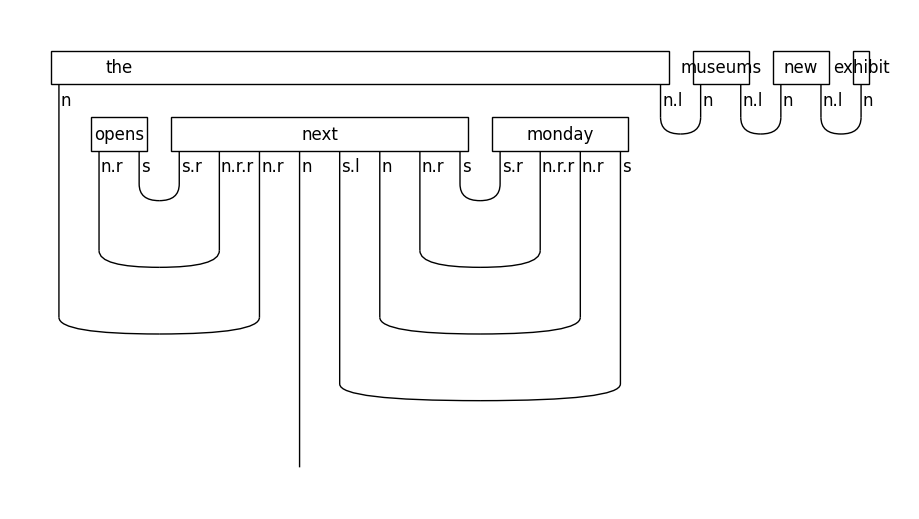

In [17]:
train_diagrams_filter[11].normal_form().draw(figsize=(9, 5), fontsize=12)

## Diagram 2 Circuit

In [18]:
from lambeq import AtomicType, IQPAnsatz, SpiderAnsatz
from lambeq.backend.tensor import Dim

# Define types for the ansatz
noun = AtomicType.NOUN
sentence_type = AtomicType.SENTENCE
prep = AtomicType.PREPOSITIONAL_PHRASE

# Create an ansatz (SpiderAnsatz and we increase the number of qubits at the exists to allow more classes)
ansatz = SpiderAnsatz({prep:Dim(4), noun: Dim(4), sentence_type: Dim(4)})

train_circuits = []
test_circuits =  []

# Create the circuits for the train and test diagrams, and catch any exceptions that might occur,
# Print out the sentences that fail
for index, diag in enumerate(train_diagrams_filter):
    try:
        train_circuits.append(ansatz(diag))
    except Exception as e:
        print("Problem with Train diagram",index, "-> sentence is:", train_dataset.iloc[index,0])
        train_labels[index] = None
        print(e)

for index,diag in enumerate(test_diagrams_filter):
    try:
        test_circuits.append(ansatz(diag))
    except Exception as e:
        print("Problem with Test diagram",index, "-> sentence is:", test_dataset.iloc[index,0])
        test_labels[index] = None
        #print(e)


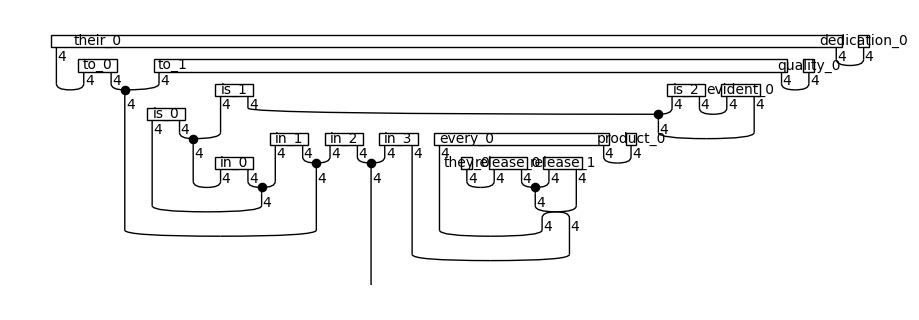

In [19]:
# Let us visualise how the spider circuits look like
train_circuits[0].draw(figsize=(9, 3))

In [20]:
# Remove the necessary labels in case of circuit conversion fail
train_labels = remove_none(train_labels)
test_labels = remove_none(test_labels)

In [21]:
print("Number of Train circuits", len(train_circuits), "and labels", len(train_labels), "match? ->", len(train_circuits) == len(train_labels))
print("Number of Test circuits", len(test_circuits), "and labels", len(test_labels), "match? ->", len(test_circuits) == len(test_labels))

Number of Train circuits 122 and labels 122 match? -> True
Number of Test circuits 33 and labels 33 match? -> True


## Training

In this section we will train a model that will predict given a circuit, its 4 possible sentiment

In [22]:
# Define the accuracy function that will be used for the training
import numpy as np

acc = lambda y_hat, y: np.sum(np.round(y_hat.detach().numpy()) == y) / len(y)/2

eval_metrics = {"acc": acc}

In [23]:
# Variable definition
BATCH_SIZE = 30
EPOCHS = 30
LEARNING_RATE = 0.03

In [24]:
# Create the model
from lambeq import PytorchModel

all_circuits = train_circuits + test_circuits
model = PytorchModel.from_diagrams(all_circuits)

In [25]:
# Create the trainer that will learn
from lambeq import PytorchTrainer, SPSAOptimizer
from lambeq import BinaryCrossEntropyLoss

bce = BinaryCrossEntropyLoss()

trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text')

In [26]:
# Collect the circuit data for convenience
from lambeq import Dataset

new_train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)

new_test_dataset = Dataset(test_circuits, test_labels, shuffle=False)

In [27]:
# Fit the data to learn and predict given the test circuits
trainer.fit(new_train_dataset, new_test_dataset, eval_interval=1, log_interval=5)

Epoch 5:   train/loss: 0.5292   valid/loss: 0.7325   train/acc: 0.0000   valid/acc: 0.0000
Epoch 10:  train/loss: 0.4169   valid/loss: 1.3433   train/acc: 0.0000   valid/acc: 0.0000
Epoch 15:  train/loss: 0.0004   valid/loss: 2.0702   train/acc: 0.0000   valid/acc: 0.0000
Epoch 20:  train/loss: 0.0000   valid/loss: 2.1509   train/acc: 0.0000   valid/acc: 0.0000
Epoch 25:  train/loss: 0.0000   valid/loss: 2.2179   train/acc: 0.0000   valid/acc: 0.0000
Epoch 30:  train/loss: 0.0000   valid/loss: 1.9259   train/acc: 0.0000   valid/acc: 0.0000

Training completed!


In [28]:
# Print out the accuracy of the prediction for the test dataset 
print(acc(model(test_circuits), test_labels))

0.7727272727272727


Let us now visualise the training with accuracy and loss

Test accuracy: 0.0


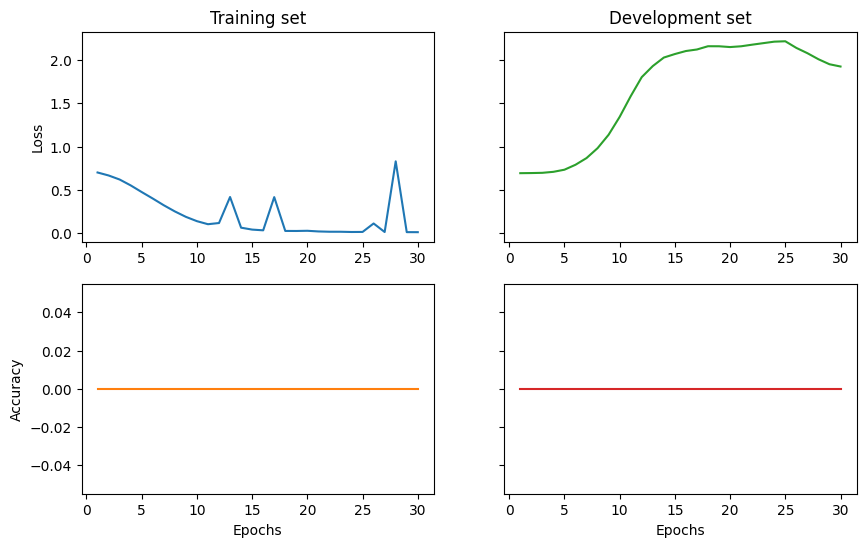

In [29]:
import matplotlib.pyplot as plt
import numpy as np

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
test_acc = acc(model(test_circuits), torch.tensor(test_labels))
print('Test accuracy:', test_acc.item())